# Amplitude Matching for Multizone Sound Field Control

A multizone sound field control method to synthesize a desired amplitude (or magnitude) distributions over a target region with multiple loudspeakers
- Paper: https://doi.org/10.1109/TASLP.2022.3231715
- Codes: https://github.com/sh01k/AmplitudeMatching

by Takumi Abe, [Shoichi Koyama](https://www.sh01.org/), [Natsuki Ueno](https://natsuenono.github.io/), and [Hiroshi Saruwatari](https://researchmap.jp/read0102891/)

## Codes for reproducing results in Sect. IV-B
### General settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as distfuncs

import sf_func as sf

In [2]:
plt.rcParams["font.size"] = 18 # Font size for plots

c = 340 # Sound speed (m/s)

# Simulated rectangular region 
lenX = 4.0 # Length in y
lenY = 4.0 # Length in y

dx, dy = 0.05, 0.05 # Intervals

# Simulated positions
xvecSim = np.arange(-lenX/2.0, lenX/2.0 + dx, dx)
yvecSim = np.arange(-lenY/2.0, lenY/2.0 + dy, dy)
ySim, xSim = np.meshgrid(yvecSim, xvecSim)
posSim = np.concatenate([xSim.reshape([-1,1]), ySim.reshape([-1,1])], 1)

# Number of simulated positions
numSimX = xSim.shape[0]
numSimY = xSim.shape[1]
numSim = (numSimX, numSimY)

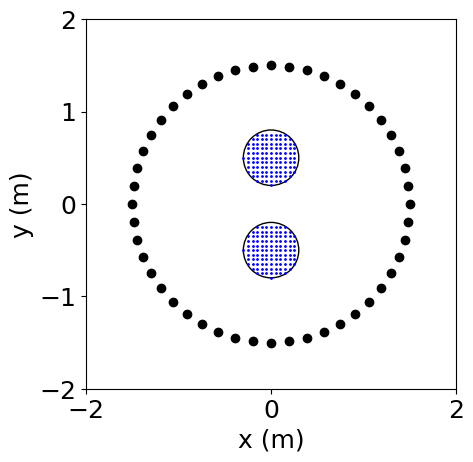

In [3]:
"""Parameters"""
radSPK = 1.5 # Radius of circlular loudspeaker array
numSPK = 48 # Number of loudspeakers
posSPK = sf.CircularGrid(radSPK, numSPK) # Loudspeaker positions

radCP = 0.3 # Radius of circular target regions
centCP_U = np.array([0.0, 0.5])[None,:] # Center position of upper target region
centCP_L = np.array([0.0, -0.5])[None,:] # Center position of lower target region
centCP = np.concatenate([centCP_U, centCP_L], 0)

# Control points in upper target region
distCP_U = distfuncs.cdist(posSim, centCP_U)
idxCP_U = np.where(distCP_U <= radCP)[0]
posCP_U = posSim[idxCP_U, :] 
numCP_U = posCP_U.shape[0]

# Control points in lower target region
distCP_L = distfuncs.cdist(posSim, centCP_L)
idxCP_L = np.where(distCP_L <= radCP)[0]
posCP_L = posSim[idxCP_L, :] 
numCP_L = posCP_L.shape[0]

idxCP = np.concatenate([idxCP_U, idxCP_L]) # Indexes of total control points
posCP = posSim[idxCP, :] # Position of total control points
numCP = posCP.shape[0] # Number of control points

# Desired amplitude distribution
des_U = np.ones(numCP_U)
des_L = np.zeros(numCP_L)
des = np.concatenate([des_U, des_L])

# Draw points
fig, ax = plt.subplots()
ax.scatter(posSPK[:,0], posSPK[:,1], c='k')
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posCP[:,0], posCP[:,1], s=1, c='b')
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

### Figures 12, 13, and 14: Time-domain filters and their magnitude and pahse responses

In [4]:
"""Parameters"""
numFreq = 1024 #set to 16384 for reproducing Figs. 12, 13, and 14, but it requires long time
freqVec = np.linspace(0, 8000, numFreq+1)[1:]
k = 2.0 * np.pi * freqVec / c # Wave number

idxEval = 10 # Loudspeaker index used for evaluation

# Transfer Function Matrices
G = sf.TransFuncMat(posSPK, posCP, k[:,None,None])

# Regularization parameter
U, s, V = np.linalg.svd(np.transpose(G.conj(),(0,2,1)) @ G)
reg = np.max(s, axis=1) * 1e-3

In [5]:
"""Pressure matching (PM) with zero phase"""
drvPM0 = sf.PressureMatching(G, reg[:,None,None], posSPK, des[None,:,None])

In [6]:
"""Amplitude matching with l2-norm penalty"""
# Parameters
dtol = 1e-3
max_iter = 1000

drvAM_ADMM_l2 = np.zeros([numFreq, numSPK]).astype("complex")
for i in range(numFreq):
    if i % 100 == 0:
        print("i: %d, freq: %f" % (i, freqVec[i]) )
    Gi = np.squeeze(G[i,:,:])
    regi = np.squeeze(reg[i])
    drv0 = np.squeeze(drvPM0[i,:])
    drvAM_ADMM_l2[i,:], _ = sf.ADMM(numSPK, des, Gi, regi, drv0, max_iter=max_iter, dtol=dtol)

i: 0, freq: 0.488281
i: 100, freq: 49.316406
i: 200, freq: 98.144531
i: 300, freq: 146.972656
i: 400, freq: 195.800781
i: 500, freq: 244.628906
i: 600, freq: 293.457031
i: 700, freq: 342.285156
i: 800, freq: 391.113281
i: 900, freq: 439.941406
i: 1000, freq: 488.769531
i: 1100, freq: 537.597656
i: 1200, freq: 586.425781
i: 1300, freq: 635.253906
i: 1400, freq: 684.082031
i: 1500, freq: 732.910156
i: 1600, freq: 781.738281
i: 1700, freq: 830.566406
i: 1800, freq: 879.394531
i: 1900, freq: 928.222656
i: 2000, freq: 977.050781
i: 2100, freq: 1025.878906
i: 2200, freq: 1074.707031
i: 2300, freq: 1123.535156
i: 2400, freq: 1172.363281
i: 2500, freq: 1221.191406
i: 2600, freq: 1270.019531
i: 2700, freq: 1318.847656
i: 2800, freq: 1367.675781
i: 2900, freq: 1416.503906
i: 3000, freq: 1465.332031
i: 3100, freq: 1514.160156
i: 3200, freq: 1562.988281
i: 3300, freq: 1611.816406
i: 3400, freq: 1660.644531
i: 3500, freq: 1709.472656
i: 3600, freq: 1758.300781
i: 3700, freq: 1807.128906
i: 3800, fr

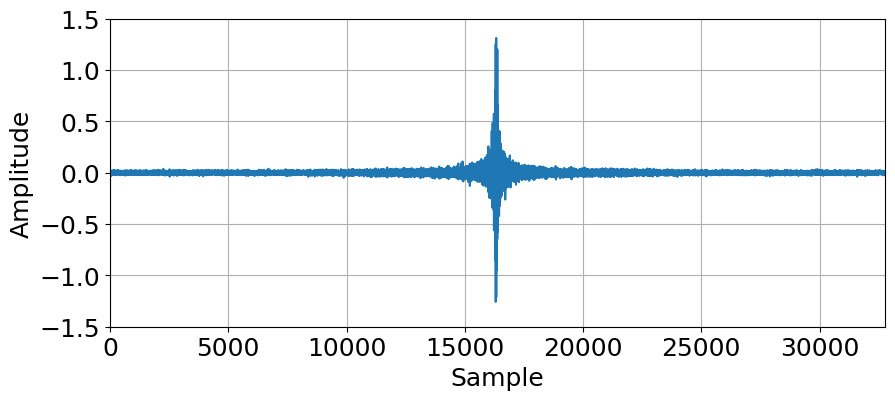

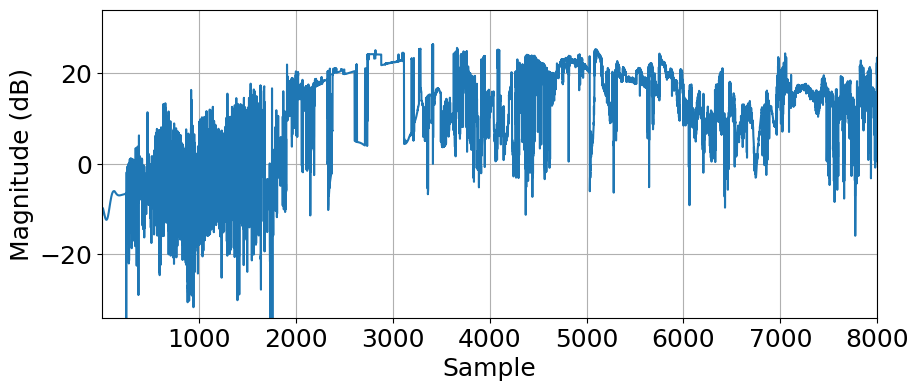

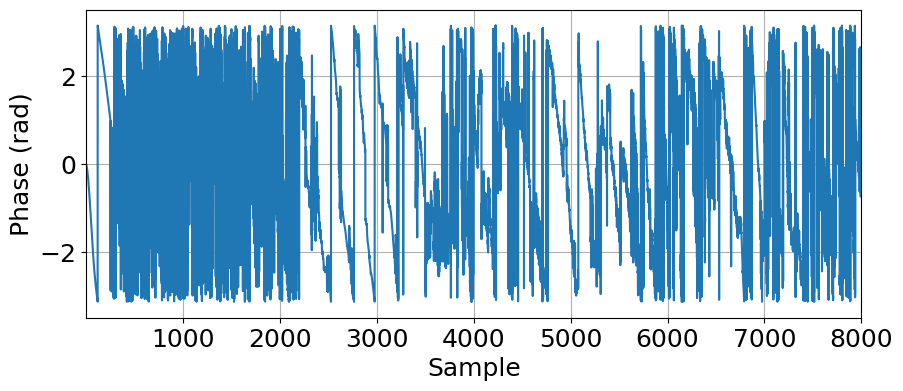

In [7]:
fftlen = numFreq*2
filterLen = fftlen
smplShift = int(fftlen/2)

specAM_ADMM_l2 = np.concatenate( (np.zeros((1,numSPK)), drvAM_ADMM_l2, drvAM_ADMM_l2[int(fftlen/2)-2::-1,:].conj()) )
sigAM_ADMM_l2 = np.fft.ifft(specAM_ADMM_l2.conj(), n=fftlen, axis=0).real
sigAM_ADMM_l2 = np.concatenate( (sigAM_ADMM_l2[fftlen-smplShift:fftlen,:], sigAM_ADMM_l2[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sigAM_ADMM_l2[:,idxEval])
ax.set_xlim(0,fftlen)
ax.set_ylim(-1.5,1.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, 20*np.log10( np.abs(drvAM_ADMM_l2[:,idxEval]) ))
ax.set_xlim(np.min(freqVec),np.max(freqVec))
ax.set_ylim(-34,34)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Magnitude (dB)')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, np.angle(drvAM_ADMM_l2[:,idxEval]) )
ax.set_xlim(np.min(freqVec),np.max(freqVec))
ax.set_ylim(-3.5,3.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Phase (rad)')

plt.show()

In [8]:
"""Amplitude matching with differential-norm penalty"""
# Parameters
dtol = 1e-3
max_iter = 1000

regDiff = 25 

drvAM_ADMM_diff = sf.ADMMdiff(numSPK, numCP, numFreq, des, regDiff, drvPM0, G, max_iter=max_iter, dtol=dtol)

Balancer:  8192
Initializing......
itr: 0, ddiff: 1.161359
itr: 100, ddiff: 0.041678
itr: 200, ddiff: 0.037977
itr: 300, ddiff: 0.036326
itr: 400, ddiff: 0.036531
itr: 500, ddiff: 0.035542
itr: 600, ddiff: 0.035374
itr: 700, ddiff: 0.035195
itr: 800, ddiff: 0.035037
itr: 900, ddiff: 0.034938


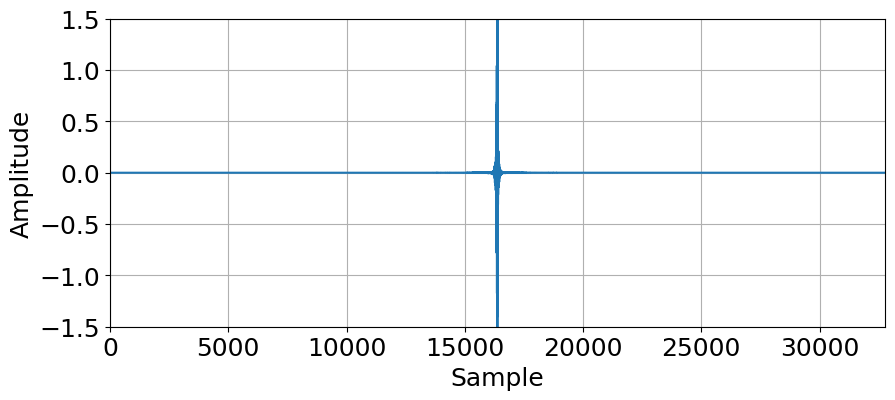

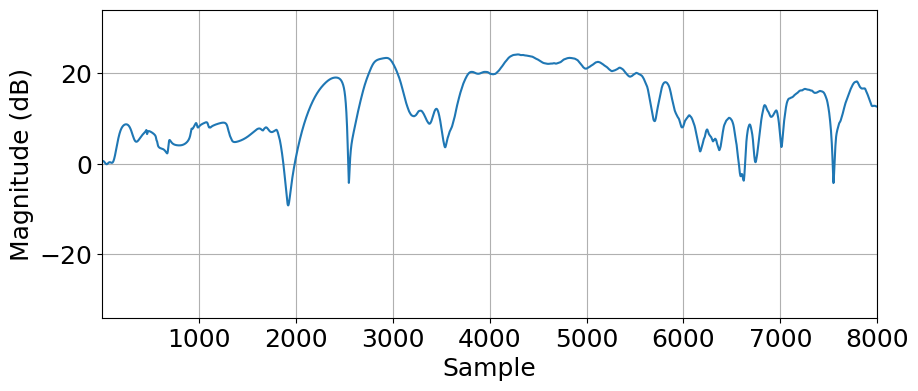

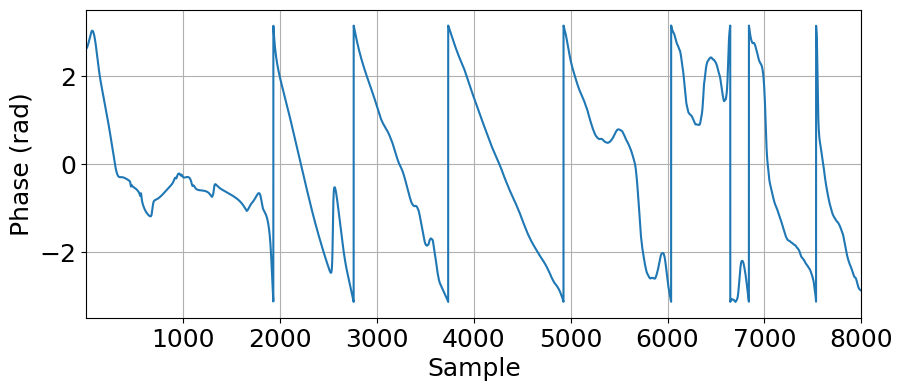

In [9]:
fftlen = numFreq*2
filterLen = fftlen
smplShift = int(fftlen/2)

specAM_ADMM_diff = np.concatenate( (np.zeros((1,numSPK)), drvAM_ADMM_diff, drvAM_ADMM_diff[int(fftlen/2)-2::-1,:].conj()) )
sigAM_ADMM_diff = np.fft.ifft(specAM_ADMM_diff.conj(), n=fftlen, axis=0).real
sigAM_ADMM_diff = np.concatenate( (sigAM_ADMM_diff[fftlen-smplShift:fftlen,:], sigAM_ADMM_diff[:filterLen-smplShift,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(sigAM_ADMM_diff[:,idxEval])
ax.set_xlim(0,fftlen)
ax.set_ylim(-1.5,1.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, 20*np.log10( np.abs(drvAM_ADMM_diff[:,idxEval]) ))
ax.set_xlim(np.min(freqVec),np.max(freqVec))
ax.set_ylim(-34,34)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Magnitude (dB)')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec, np.angle(drvAM_ADMM_diff[:,idxEval]) )
ax.set_xlim(np.min(freqVec),np.max(freqVec))
ax.set_ylim(-3.5,3.5)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Phase (rad)')

plt.show()

### Figure 15: Performance in broadband case

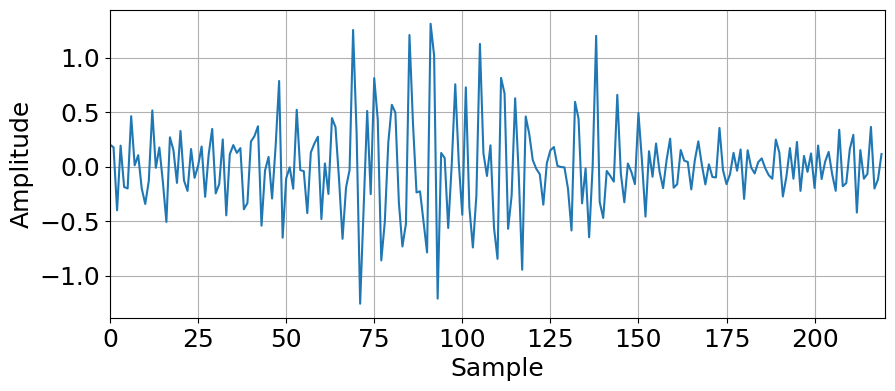

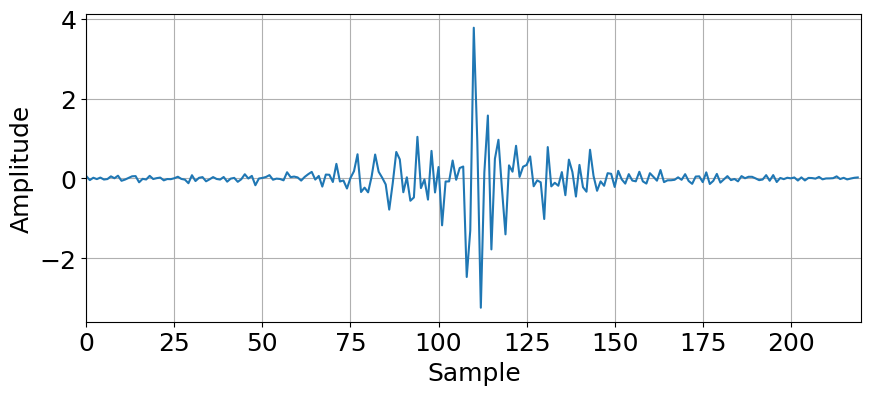

In [10]:
"""Compute filters"""
filterLen = 220

pwavAM_ADMM_l2 = 10*np.log10( np.sum( np.abs(sigAM_ADMM_l2)**2, axis=1 ))
idxPeak_l2 = np.argmax( pwavAM_ADMM_l2 ) # Peak index
smplShift_l2 = int( filterLen/2 + (fftlen/2 - idxPeak_l2) ) 
filterAM_ADMM_l2 = np.fft.ifft(specAM_ADMM_l2.conj(), n=fftlen, axis=0).real
filterAM_ADMM_l2 = np.concatenate( (filterAM_ADMM_l2[fftlen-smplShift_l2:fftlen,:], filterAM_ADMM_l2[:filterLen-smplShift_l2,:]) )

pwavAM_ADMM_diff = 10*np.log10( np.sum( np.abs(sigAM_ADMM_diff)**2, axis=1 ) ) 
idxPeak_diff = np.argmax( pwavAM_ADMM_diff ) # Peak index
smplShift_diff = int( filterLen/2 + (fftlen/2 - idxPeak_diff) ) 
filterAM_ADMM_diff = np.fft.ifft(specAM_ADMM_diff.conj(), n=fftlen, axis=0).real
filterAM_ADMM_diff = np.concatenate( (filterAM_ADMM_diff[fftlen-smplShift_diff:fftlen,:], filterAM_ADMM_diff[:filterLen-smplShift_diff,:]) )

# Plot filter
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(filterAM_ADMM_l2[:,idxEval])
ax.set_xlim(0,filterLen)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(filterAM_ADMM_diff[:,idxEval])
ax.set_xlim(0,filterLen)
plt.grid()
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.show()

Text(0, 0.5, 'y (m)')

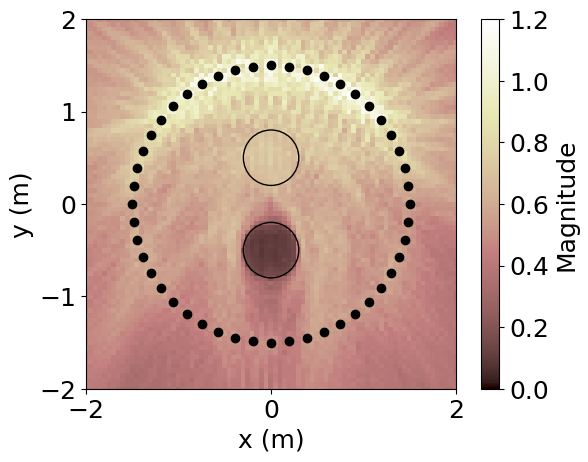

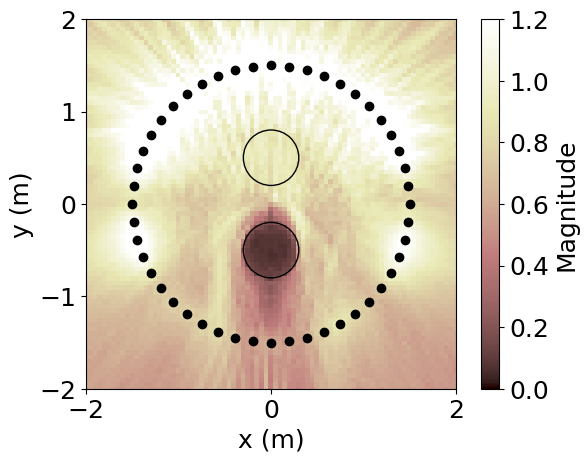

In [11]:
"""Synthesized sound field"""
fftlen = 1024
numFreq = int(fftlen/2)
freqVec_syn = np.linspace(0, 8000, numFreq+1)[1:]
k = 2.0 * np.pi * freqVec_syn / c # Wave number

# AM w/ l2-norm penalty
fltspecAM_ADMM_l2 = np.fft.fft(filterAM_ADMM_l2, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_l2, _ = sf.SynthSoundField(posSim, posSPK, fltspecAM_ADMM_l2.conj(), numSim, k)
synspecAM_ADMM_l2 = np.concatenate( (np.zeros((1,numSim[0]*numSim[1])), synspecAM_ADMM_l2, synspecAM_ADMM_l2[int(fftlen/2)-2::-1,:].conj()) )
synAM_ADMM_l2 = np.fft.ifft(synspecAM_ADMM_l2.conj(), n=fftlen, axis=0).real
synampAM_ADMM_l2 = np.sqrt( np.sum(np.abs(synAM_ADMM_l2)**2, axis=0) )
synampAM_ADMM_l2_XY =  synampAM_ADMM_l2.reshape(numSim[0], numSim[1]) 

# AM w/ differential-norm penalty
fltspecAM_ADMM_diff = np.fft.fft(filterAM_ADMM_diff, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_diff, _= sf.SynthSoundField(posSim, posSPK, fltspecAM_ADMM_diff.conj(), numSim, k)
synspecAM_ADMM_diff = np.concatenate( (np.zeros((1,numSim[0]*numSim[1])), synspecAM_ADMM_diff, synspecAM_ADMM_diff[int(fftlen/2)-2::-1,:].conj()) )
synAM_ADMM_diff = np.fft.ifft(synspecAM_ADMM_diff.conj(), n=fftlen, axis=0).real
synampAM_ADMM_diff = np.sqrt( np.sum(np.abs(synAM_ADMM_diff)**2, axis=0) )
synampAM_ADMM_diff_XY = synampAM_ADMM_diff.reshape(numSim[0], numSim[1]) 

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synampAM_ADMM_l2_XY, cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

fig, ax = plt.subplots()
color = ax.pcolor(xSim, ySim, synampAM_ADMM_diff_XY, cmap='pink', vmin=0.0, vmax=1.2)
sf.plotCircles(ax, centCP, radCP)
ax.scatter(posSPK[:,0], posSPK[:,1], color="k")
ax.axis([posSim[:,0].min(), posSim[:,0].max(), posSim[:,1].min(), posSim[:,1].max()])
ax.set_aspect('equal')
cbar=plt.colorbar(color)
cbar.set_label('Magnitude')
plt.xlabel('x (m)')
plt.ylabel('y (m)')

AD w/ l2-norm: -10.5, AM w/ Diff. norm: -16.9


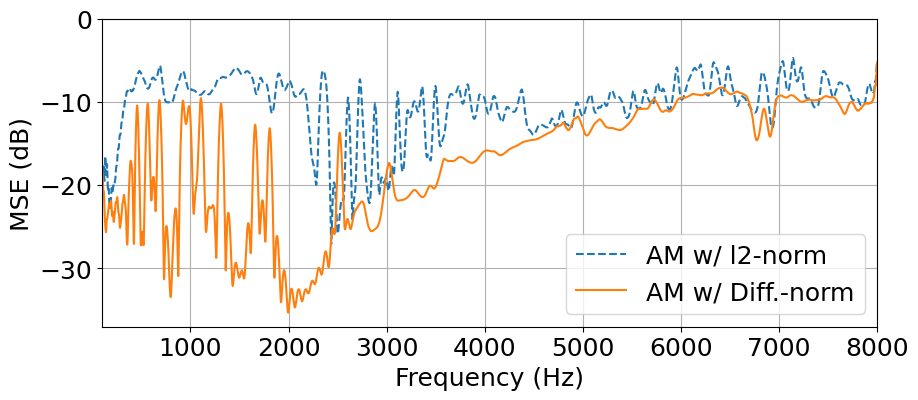

In [12]:
"""Evaluation"""
fftlen = 32768
numFreq = int(fftlen/2)
freqVec_eval = np.linspace(0, 8000, numFreq+1)[1:]
synspecAM_ADMM_l2 = np.fft.fft(synAM_ADMM_l2, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]
synspecAM_ADMM_diff = np.fft.fft(synAM_ADMM_diff, n=fftlen, axis=0)[1:int(fftlen/2)+1,:]

MSEvec_AM_ADMM_l2 = []
MSEvec_AM_ADMM_diff = []

for i in range(numFreq):
    MSEvec_AM_ADMM_l2.append(sf.MSE(synspecAM_ADMM_l2[i,idxCP], des))
    MSEvec_AM_ADMM_diff.append(sf.MSE(synspecAM_ADMM_diff[i,idxCP], des))

MSEav_AM_ADMM_l2 = np.average(MSEvec_AM_ADMM_l2)
MSEav_AM_ADMM_diff = np.average(MSEvec_AM_ADMM_diff)

print("AD w/ l2-norm: %.1f, AM w/ Diff. norm: %.1f" % (MSEav_AM_ADMM_l2, MSEav_AM_ADMM_diff) )

# Plot
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(freqVec_eval, MSEvec_AM_ADMM_l2, linestyle="--", label="AM w/ l2-norm")
ax.plot(freqVec_eval, MSEvec_AM_ADMM_diff, linestyle="-", label="AM w/ Diff.-norm")
ax.set_xlim(100,8000)
ax.set_ylim(-37, 0)
plt.xlabel('Frequency (Hz)')
plt.ylabel('MSE (dB)')
plt.legend()
plt.grid()